Het voorspellen van de bondprijs alleen op basis van historische waarde van de bond is waarschijnlijk nooit erg succesvol. Voor een betere voorspelling zullen we 'leading indicatoren' moeten hebben. Indicatoren die iets zeggen waar de markt naar toe gaat.

Op basis van de literatuurstudie en een selectie van welke data beschikbaar was voor dit onderzoek, zijn de volgende features geselecteerd:
- Remaining Duration
- Theoretical Bond Prices
- Inflation curve
- Referentie bond (10 jaars bonds, met zelfde maturity)
- Term Spread
- Bid Offer Spread

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

from src.data import make_dataset, window, split
from src.models import base_model, evaluate, hyper
from src.visualization import visualize

Door de te verwachten kasstromen te projecteren met de rente van het contract, en te verdisconteren tegen een passend rentepercentage kan een voorspelling worden gemaakt van de 'theoretische' marktwaarde van de bond. De markt kan tijdelijk de bond door vraag en aanbod hoger of lager prijzen dan deze intrinsieke waarde, maar de verwachting is dat de prijs van de bond uiteindelijk toch niet lang zal afwijken van de intrinsieke waarde.

2022-01-30 23:42:10.276 | INFO     | src.data.make_dataset:read_pkl:392 - Load preprocessed isin data


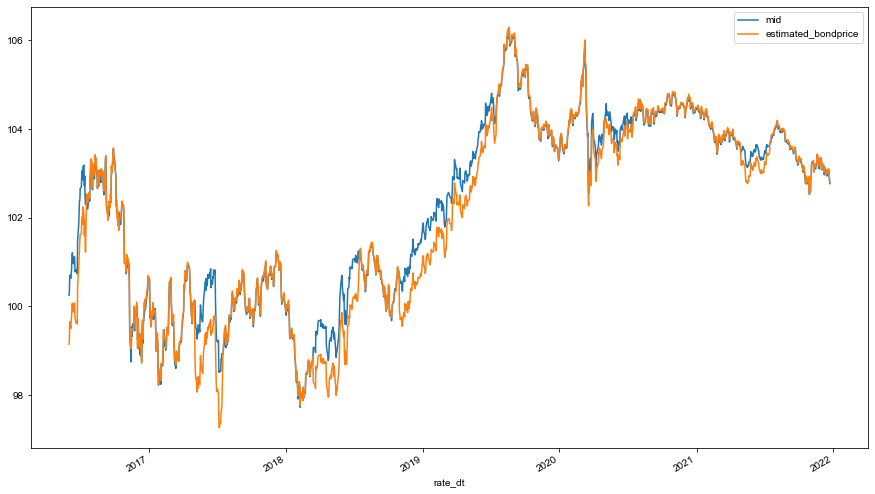

In [3]:
# Add theoretically calculated bond price
df_isin = make_dataset.read_pkl('isin', path = Path("data/processed/"), colab = IS_COLAB)
df_isin.plot(x = 'rate_dt',y = ['mid','estimated_bondprice'], figsize = (15,9))
plt.show()

In [4]:
# subset columns and sort on index
df_isin = df_isin[['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10','10 YEARS']]
df_isin.columns = ['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10y','inflation_10y']
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()

De dataset wordt weer gesplit in 70% trainingsdata en 30% test data. Dit om het model vergelijkbaar te houden met de modellen die alleen op het signaal getrained waren.

In [5]:
df_train, df_test = split.split_data(df_isin, 0.7)
scaler = MinMaxScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])


2022-01-30 23:42:11.154 | INFO     | src.data.split:split_data:19 - Train test split data 1413 70.0%,train data 989, test data 424.


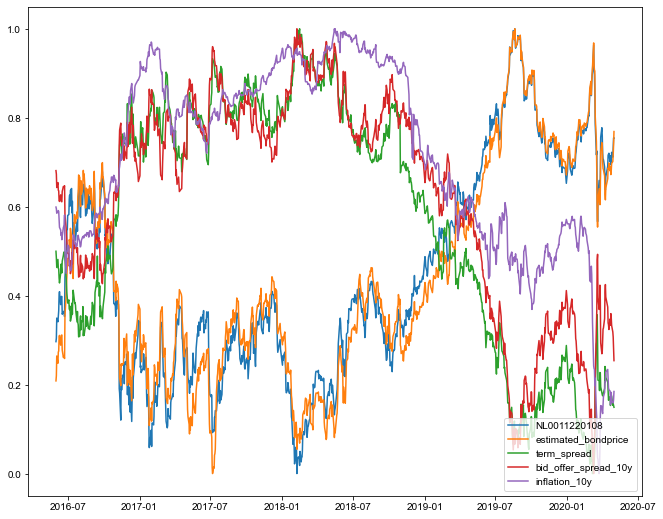

In [6]:
isin = "NL0011220108"  # 10 Years NL Bond, maturity 2025 0.25% coupon
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(df_train['mid'], label=isin)
line2, = plt.plot(df_train['estimated_bondprice'], label="estimated_bondprice")
line3, = plt.plot(df_train['term_spread'], label="term_spread")
line4, = plt.plot(df_train['bid_offer_spread_10y'], label="bid_offer_spread_10y")
line4, = plt.plot(df_train['inflation_10y'], label="inflation_10y")
leg = plt.legend(loc='lower right')


De correlatie tussen deze items is zeer opvallend. Ik zie nog niet hoe dit mogelijk is. De spread tussen bid en ask prijzen en de spread tussen 2 years en 10 years bonds volgen bijna naadloos een zelfde trend als de ontwikkeling van de marktwaarde van de bond. Wanneer we deze spreads even omdraaien wordt dit nog duidelijker. Een mogelijke verklaring hiervoor zou kunnen zijn dat deze indicatoren worden gebruikt door de algo traders in hun modellen en zodoende feitenlijk de bondprijzen bepalen. In de literatuur heb ik hier geen aanwijzingen voor gevonden.

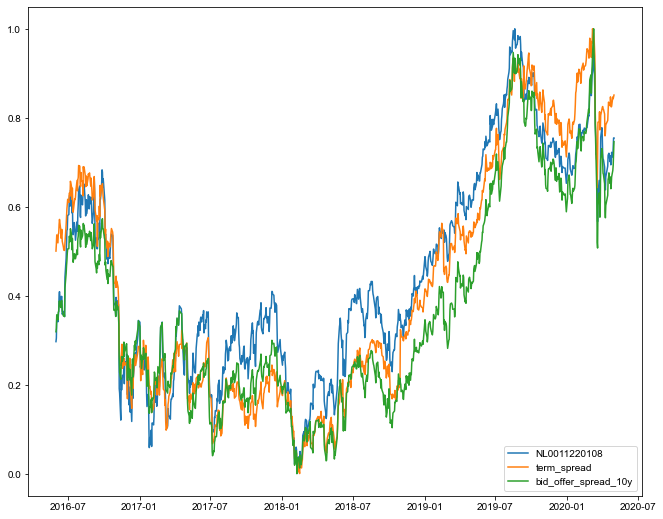

In [7]:
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(df_train['mid'], label=isin)
line3, = plt.plot(df_train['term_spread'] * -1 + 1, label="term_spread")
line4, = plt.plot(df_train['bid_offer_spread_10y'] * -1 + 1, label="bid_offer_spread_10y")
leg = plt.legend(loc='lower right')

In [8]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 64
shuffle_buffer = 4
horizon = 10
train_set = window.windowed_dataset(df_train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(df_test, window_size, batch_size, shuffle_buffer, horizon=horizon)

2022-01-30 23:42:12.614 | INFO     | src.data.window:windowed_dataset:13 - Split windowed dataset window_size = 32 batch_size =  64, shuffle_buffer =  4 ,horizon =  10
2022-01-30 23:42:13.696 | INFO     | src.data.window:windowed_dataset:13 - Split windowed dataset window_size = 32 batch_size =  64, shuffle_buffer =  4 ,horizon =  10


In [9]:
y, yhat = base_model.naivepredict(df_train.iloc[:, 0].values)
norm = evaluate.mae(y, yhat)
print('1 step Mean Absolute Error: ', evaluate.mae(y, yhat))
# Mean Absolute Error - for horizon
norm = base_model.calc_mae_for_horizon(train_set, horizon)
print(f'Mean Absolute Error for {horizon} timesteps', norm)
smae = evaluate.ScaledMAE(scale=norm)

1 step Mean Absolute Error:  0.017672397407386325
Mean Absolute Error for 10 timesteps 0.0432073185641628


In [10]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([64, 32, 5]), TensorShape([64, 10]))

In [11]:
result = {}
models = {}

In [12]:
config = {        
    'horizon'   : horizon,    
    'window'    : window_size,
    'features'  : 5
}
name = 'BaseRnnModel'
model = base_model.RnnModel(name,config)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr = 1e-2
model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop], verbose=0)
models[name] = model
print(model.evaluate(valid_set))

6/6 [==============================] - 0s 25ms/step - loss: 0.0026 - mae: 0.0414 - smae: 0.9591
[0.002634474541991949, 0.04143911227583885, 0.9590762853622437]


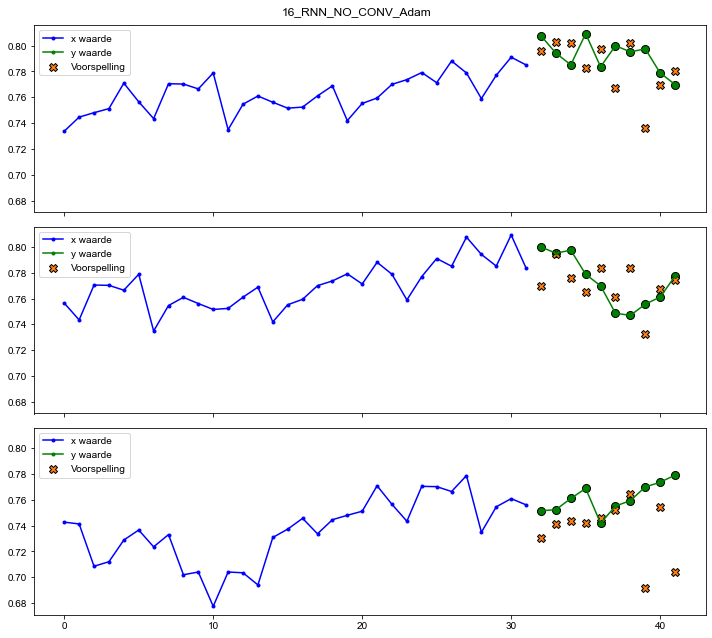

In [19]:
fig = visualize.plot_example( 
    valid_set,
    window_size = window_size,
    horizon = horizon,
    examples = 3,
    model = model,
    figurepath = Path("reports/figures"))

In [16]:
# Remove log files before tuning models
if IS_COLAB:
  !rm -rf logs/
else:
  !del logs /Q
  !del %USERPROFILE%\AppData\Local\Temp\.tensorboard-info\*.* /Q

%load_ext tensorboard

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.8,
                              patience=5, min_lr=1e-5)

key = "Adam"
name = f"16_RNN_NO_CONV_{key}"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)

config = {
    'window'        :   window_size,        
    'units'         :   16,    
    'hidden'        :   1,        
    'horizon'       :   horizon,   
    'features'      :   5 
}
model = base_model.RnnModel(name,config)
opt = tf.keras.optimizers.get(key)
opt.momentum = 0.9
opt.learning_rate = 0.01

model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])
result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                        validation_data=valid_set, verbose=0)
models[name] = model
print("Model: " + model.name, model.evaluate(valid_set))

6/6 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.0337 - mape: 4.7576 - smae: 0.7790
Model: 16_RNN_NO_CONV_Adam [0.0018326634308323264, 0.033657342195510864, 4.757558345794678, 0.7789731621742249]


In [ ]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "timeDistributed" : tune.choice([True, False]),
    "features": 5,
    "window" : tune.randint(5, 30),    
    "filters" : tune.randint(0, 32),
    "kernel" : tune.randint(1, 16),
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(16, 256, 16),
    "horizon" : 10,
    "shape3d" : True,    
    "activation": tune.choice(["relu", "tanh", None]),
}

In [ ]:
analysis = hyper.hypertune(df_train, df_test, config)

In [ ]:
config = analysis.get_best_config()
config


In [ ]:
window_size = config["window"]
horizon = config["horizon"]
train_set = window.windowed_dataset(
    df_train, window_size, batch_size=256, shuffle_buffer=2, horizon=horizon
)
valid_set = window.windowed_dataset(
    df_train, window_size, batch_size=256, shuffle_buffer=2, horizon=horizon
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, min_lr=1e-5
)
opt = tf.keras.optimizers.get(config["optimizer"])
opt.momentum = 0.9
opt.learning_rate = 0.01
model = hyper.HyperRnn(config)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

result["hypertuned"] = model.fit(
        train_set,
        epochs=150,
        validation_data=valid_set,
        callbacks=[reduce_lr, early_stop],
    )
models["hypertuned"] = model

In [ ]:
fig = visualize.plot_example(
    valid_set, 
    window_size = window_size, 
    horizon = horizon, 
    examples = 3, 
    model = model,
    figurepath = Path("reports/figures"), 
    name = 'example base model')